In [91]:
%config InlineBackend.figure_formats = ['svg']

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
from tqdm import tqdm_notebook as tqdm
import pickle
import os
from typing import List, Dict, Sequence, Tuple

In [92]:
os.chdir("/Users/edwardgan/Documents/Projects/sketchstore/python")

In [93]:
import sketch.compress_freq
import sketch.sketch_frequent
import sketch.compress_dyadic
import sketch.sketch_gen
import storyboard.board_gen
import cube_board
import cube_rquery

In [94]:
def get_error_file(
    data_name: str, split_strategy: str,
    board_size: int, sketch_name: str,
    bias: bool, workload_p: float
) -> str:
    sketch_file = cube_board.get_file_name(data_name, split_strategy, board_size, sketch_name, bias)
    error_file = cube_rquery.transform_sketch_to_error_file(sketch_file, workload_p)
    return error_file

In [95]:
def human_format(x):
    sigpart = 0
    suffix = ""
    if x < .01:
        return "{:.0e}".format(x)
    if x < 1:
        return "{:.2f}".format(x)
    if x < 1000:
        return "{:.3g}".format(x)
    elif x < 1000000:
        sigpart = x / 1000
        suffix = "k"
    elif x < 1000000000:
        sigpart = x / 1000000
        suffix = "M"
    else:
        sigpart = x / 1000000000
        suffix = "B"
    return "{:.3g}{}".format(sigpart, suffix)
def bar_plot(ax, ys, yerr=None, log=False, label=False, ylims=None):
    n = len(ys)
    xlocs = np.arange(0, n)
    ax.bar(
        xlocs,
        height=ys,
        yerr=yerr,
        log=log,
    )
    if (label):
        rects = ax.patches
        for rect, label in zip(rects, ys):
            height = rect.get_height()
            y_pos = height
            if ylims is not None:
                if y_pos < ylims[0]:
                    y_pos = ylims[0]
            ax.text(
                rect.get_x() + rect.get_width()/2, 
                y_pos,
                human_format(label),
                ha='center', va='bottom', size = 8,
            )
    ax.set_xticks(xlocs)

In [80]:
method_names = {
    ("pps", "weighted@20", True): "Storyboard",
    ("random_sample", "uniform", False): "Sampling",
    ("random_sample", "prop", False): "Sampling:Prop",
    ("truncation", "uniform", False): "Truncation",
    ("cms_min", "uniform", False): "Count-Min",

    ("pps", "uniform", True): "SB w/o Size Opt",
    ("pps", "weighted@20", False): "SB w/o Bias Opt",
    ("random_sample", "weighted@20", True): "SB w Sampling",
}

colormap = {
    ("pps", "weighted@20", True): "C0",
    ("random_sample", "uniform", False): "C1",
    ("random_sample", "prop", False): "C2",
    ("truncation", "uniform", False): "C3",
    ("cms_min", "uniform", False): "C4",

    ("pps", "uniform", True): "C5",
    ("pps", "weighted@20", False): "C6",
    ("random_sample", "weighted@20", True): "C7",
}
markers = {
    ("pps", "weighted@20", True): "x",
    ("random_sample", "uniform", False): "+",
    ("random_sample", "prop", False): "s",
    ("truncation", "uniform", False): "^",
    ("cms_min", "uniform", False): "o",

    ("pps", "uniform", True): "<",
    ("pps", "weighted@20", False): ">",
    ("random_sample", "weighted@20", True): "D",
}


In [99]:
def gen_cube_plots(
    data_name: str,
    board_size: int,
    workload_p: float,
    board_params: Sequence[Tuple],
):
    e_fnames = [
        get_error_file(
            data_name, 
            split_strategy=split_strategy,
            board_size=board_size, 
            sketch_name=sketch_name,
            bias=bias,
            workload_p=workload_p, 
        )
        for sketch_name,split_strategy,bias in board_params
    ]
    e_dfs = [pd.read_csv(f) for f in e_fnames]
    e_combined = pd.concat(e_dfs, axis=0)
    e_combined["max_n"] = e_combined["max"] / e_combined["total"]
    eg1 = e_combined.groupby(["sketch", "_split_strategy", "_bias_opt"]).aggregate({
        "max_n": ["mean", "std", "count"],
    })
    eg1["stde"] = eg1["max_n", "std"]/np.sqrt(eg1["max_n", "count"])
    eg2 = e_combined.groupby(["sketch", "_split_strategy", "_bias_opt", "query_len"]).aggregate({
        "max_n": ["mean", "std", "count"],
    })
    eg2["stde"] = eg2["max_n", "std"]/np.sqrt(eg2["max_n", "count"])

    f = plt.figure()
    ax = f.gca()
    core_methods = [
            ("pps", "weighted@20", True),
            ("random_sample", "uniform", False),
            ("random_sample", "prop", False),
            ("truncation", "uniform", False),
            ("cms_min", "uniform", False),

            ("pps", "uniform", True),
            ("pps", "weighted@20", False),
    ]
    names = [method_names[i] for i in core_methods]
    ys = [eg1["max_n", "mean"].loc[i] for i in core_methods]
    yerrs = [eg1["stde"].loc[i] for i in core_methods]
    bar_plot(ax, ys, yerrs, label=True)
    # ax.yaxis.grid(True)
    ax.set_ylabel("Average Maximum Error")
    ax.set_xticklabels(names, rotation=-55)
    ax.set_title(data_name)
    f.tight_layout()
    fname1= "output/plots/cube_global_{}.pdf".format(data_name)
    f.savefig(fname1, bbox_inches='tight')
    
    f = plt.figure()
    ax = f.gca()
    core_methods = [
            ("pps", "weighted@20", True),
            ("random_sample", "uniform", False),
            ("random_sample", "prop", False),
            ("truncation", "uniform", False),
            ("cms_min", "uniform", False),
    ]
    for method_idx in core_methods:
        cur_name = method_names[method_idx]
        ys = eg2["max_n", "mean"].loc[method_idx]
        yerrs = eg2["stde"].loc[method_idx]
        ax.errorbar(
            ys.index, ys, yerr=yerrs, 
            label=cur_name,
            color=colormap[method_idx],
            marker=markers[method_idx],
        )
    # ax.yaxis.grid(True)
    ax.set_ylabel("Average Maximum Error")
    ax.set_xlabel("# Dimension Filters")
    ax.set_yscale("log")
    # ax.set_xticklabels(names, rotation=-55)
    ax.set_title(data_name)
    ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
    lgd = ax.legend(frameon=False, loc='upper center', bbox_to_anchor=(0.5, 1.35), ncol=3)
    f.tight_layout()
    fname = "output/plots/cube_query_{}.pdf".format(data_name)
    f.savefig(fname, bbox_extra_artists=(lgd,), bbox_inches='tight')

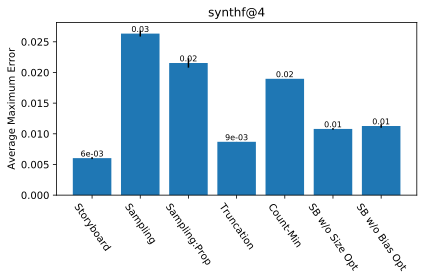

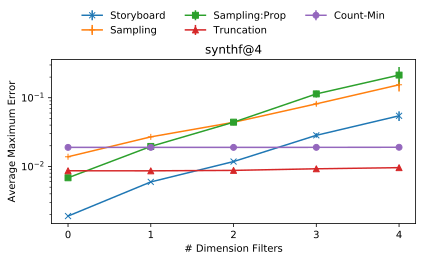

In [100]:
data_name = "synthf@4"
board_size = 2048
workload_p = .2
board_params = [
        ("pps", "weighted@20", True),
        ("random_sample", "uniform", False),
        ("random_sample", "prop", False),
        ("truncation", "uniform", False),
        ("cms_min", "uniform", False),

        ("pps", "uniform", True),
        ("pps", "weighted@20", False),
        ("random_sample", "weighted@20", True),
]

gen_cube_plots(
    data_name,
    board_size,
    workload_p,
    board_params
)